I am going to simulate a fiber coupler that consist in two parallel fibers with the Beam Propagation Method using fast Fourier transforms.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # libreria para generar graficas
import numpy as np #libreria númerica que da superpoderes para importar y manipular numeros
from math import hypot as hyp

In [2]:
# I define a function for the index of refraction of two identical parallel fibers
def index_parallel_fibers(x,y,r,R,n_r,n_R,d):
    #x,y are the positions
    #r is the radius of the core
    #R is the radius of the cladding
    #n_r the index of the core
    #n_R the index of the cladding
    #d the distance between the fibers
    n_air=1.00029
    
#The center of the coordinate system is the center of one fibers, and the other fiber is centered in
#x=2R+d , y=0
    c_fiber=2*R+d
    r_d=np.hypot(x,y) #distance from the center of the first fiber
    r_d_2=np.hypot(x-c_fiber,y) #distance from the center of the second fiber
    if r_d<=R:
        if r_d<=r:
            n=n_r
        else:
            n=n_R
    elif r_d_2<=R:
        if r_d_2<=r:
            n=n_r
        else:
            n=n_R
    else:
        n=n_air
    return n          

I check that it works. I took the parametrs from [Evanescent field coupling ...](https://www.researchgate.net/publication/221828819_Evanescent_field_coupling_between_two_parallel_close_contact_SMS_fiber_structures)

In [3]:
r=50e-6
R=125e-6
n_r=1.446
n_R=1.4271
d=2e-6

I am going to work in adimensional units, every distance parameter is going to be rescaled by the radius of the core. The parameters in the Fourier space are going to be rescaled by the inverse of the radius.

In [4]:
Ra=R/r
da=d/r
ra=1
wavelength=1550e-9
k=2*np.pi/wavelength
ka=k*r
W=20 #I am going to simulate a rectangular region of 20x20 radius^2
N=512 #Number of divisions in one axis of the simulated region
step=W/N

In [5]:
left_border=Ra+da/2-W/2
upper_border=W/2
region=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x=left_border+i*step
        y=upper_border-j*step
        region[j,i]=index_parallel_fibers(x,y,ra,Ra,n_r,n_R,da)
        

I present the index of the simulated region.

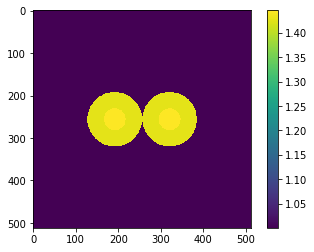

In [6]:
plt.imshow(region)
plt.colorbar()

I prepare a Gaussian beam, that it is incident in the fiber at the left. First I define a matrix for x positions, and other matrix for the y positions.

In [7]:
x_axis=[left_border+i*step for i in range(N)]
x_matrix=np.tile(x_axis, (N,1))
y_axis=[[upper_border-j*step] for j in range(N)]
y_matrix=np.tile(y_axis, (1,N))

In [8]:
width=ra
A0=2
Gauss_beam=A0*np.exp(-(x_matrix**2+y_matrix**2)/width**2)

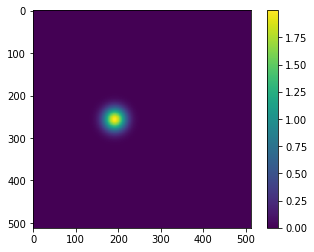

In [9]:
plt.imshow(Gauss_beam)
plt.colorbar()

I am going to propagate 50mm, and I am going to choose a propagation step of 1$\mu$m. I also need to adimensionalize this numbers.

In [31]:
zf=50e-3 #First I start with 1mm
dz=1e-6
zf_a=zf/r
dz_a=dz/r

#The Fourier space .As I have defined a r unit in the configuration space, the natural unit in the Fourier space is 1/r
step_F=1/W

#Matrices for the Fourier space. I have to center this coordinate system
center_f_x=int((W/2-Ra-da/2)/step)
frequency_x=[i*step_F for i in range(-center_f_x,N-center_f_x)]
frequency_y=[i*step_F for i in range(int(N/2),int(-N/2),-1)]
fx_matrix,fy_matrix=np.meshgrid(frequency_x,frequency_y)

In adimensional units the transfer function is rewriten as:

$TF=e^{i\Delta z_a \sqrt{n_r^2ka^2-4\pi^2(f_{xa}^2+f_{ya}^2)}}$

where $ka=kr$ and $f_{xa}=f_xr$

In [11]:
# Transfer function
TF=np.exp(1j*dz_a*np.sqrt(n_r**2*ka**2-4*np.pi*(fx_matrix**2+fy_matrix**2)))

I calculate the phase correction mask

In [24]:
PC=np.exp(1j*dz_a*ka*(region-n_r))

I am only going to save the power in each fiber at each stage of the propagation. If I save the shape and phase at each step I am going to have an array of shape $512\times 512 \times 1000$. 

The power will be the sum of the intensities at each fiber.

In [12]:
def power_fibers(Ra,da,x_matrix,y_matrix,simulation):
    intensity_f1=np.where(np.hypot(x_matrix,y_matrix)<Ra,simulation,np.zeros(x_matrix.shape))
    c_fiber=2*Ra+da
    intensity_f2=np.where(np.hypot(x_matrix-c_fiber,y_matrix)<Ra,simulation,np.zeros(x_matrix.shape))
    intensity_f1=np.abs(intensity_f1)**2
    intensity_f2=np.abs(intensity_f2)**2
    return [np.sum(intensity_f1),np.sum(intensity_f2)]

In [13]:
power_fibers(Ra,da,x_matrix,y_matrix,Gauss_beam)

[4117.732674496479, 0.0005432884545600332]

I start the propagation routine

In [32]:
n_runs=int(zf/dz)
powers=np.zeros((n_runs,2))

In [33]:
for i in range(n_runs):
    F_Gauss=np.fft.fftshift(np.fft.fft2(Gauss_beam))  #Fourier transform of the initial condition
    F_Gauss1=np.multiply(F_Gauss,TF)
    Gauss1=np.fft.ifft2(np.fft.fftshift(F_Gauss1))
    
    Gauss1=np.multiply(Gauss1,PC) #Phase correction
    powers[i,:]=power_fibers(Ra,da,x_matrix,y_matrix,Gauss1) #Store the power
    Gauss_beam=Gauss1

Text(0.5, 1.0, '2$\\mu$m separation')

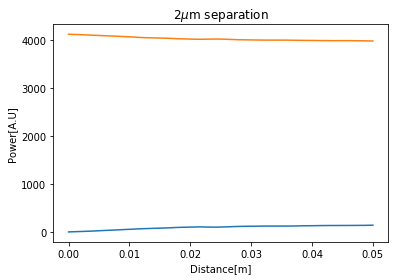

In [37]:
plt.plot([i*dz for i in range(n_runs)], powers[:,1])
plt.plot([i*dz for i in range(n_runs)], powers[:,0])
plt.xlabel("Distance[m]")
plt.ylabel("Power[A.U]")
plt.title(r"2$\mu$m separation")

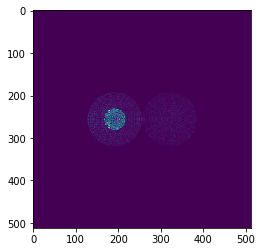

In [42]:
plt.imshow(np.abs(Gauss_beam))

I am going to try with less separation

In [38]:
d=1e-6
da=d/r

In [39]:
left_border=Ra+da/2-W/2
upper_border=W/2
region=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x=left_border+i*step
        y=upper_border-j*step
        region[j,i]=index_parallel_fibers(x,y,ra,Ra,n_r,n_R,da)

In [45]:
x_axis=[left_border+i*step for i in range(N)]
x_matrix=np.tile(x_axis, (N,1))
y_axis=[[upper_border-j*step] for j in range(N)]
y_matrix=np.tile(y_axis, (1,N))

In [46]:
width=ra
A0=2
Gauss_beam=A0*np.exp(-(x_matrix**2+y_matrix**2)/width**2)

In [47]:
zf=50e-3 #First I start with 1mm
dz=1e-6
zf_a=zf/r
dz_a=dz/r

#The Fourier space .As I have defined a r unit in the configuration space, the natural unit in the Fourier space is 1/r
step_F=1/W

#Matrices for the Fourier space. I have to center this coordinate system
center_f_x=int((W/2-Ra-da/2)/step)
frequency_x=[i*step_F for i in range(-center_f_x,N-center_f_x)]
frequency_y=[i*step_F for i in range(int(N/2),int(-N/2),-1)]
fx_matrix,fy_matrix=np.meshgrid(frequency_x,frequency_y)

In [48]:
PC=np.exp(1j*dz_a*ka*(region-n_r))

In [49]:
powers1=np.zeros((n_runs,2))
for i in range(n_runs):
    F_Gauss=np.fft.fftshift(np.fft.fft2(Gauss_beam))  #Fourier transform of the initial condition
    F_Gauss1=np.multiply(F_Gauss,TF)
    Gauss1=np.fft.ifft2(np.fft.fftshift(F_Gauss1))
    
    Gauss1=np.multiply(Gauss1,PC) #Phase correction
    powers1[i,:]=power_fibers(Ra,da,x_matrix,y_matrix,Gauss1) #Store the power
    Gauss_beam=Gauss1

Text(0.5, 1.0, '1$\\mu$m separation')

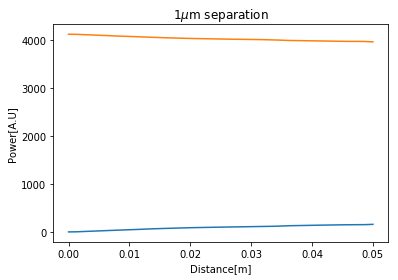

In [50]:
plt.plot([i*dz for i in range(n_runs)], powers1[:,1])
plt.plot([i*dz for i in range(n_runs)], powers1[:,0])
plt.xlabel("Distance[m]")
plt.ylabel("Power[A.U]")
plt.title(r"1$\mu$m separation")


With no separation

In [51]:
da=0
left_border=Ra+da/2-W/2
upper_border=W/2
region=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x=left_border+i*step
        y=upper_border-j*step
        region[j,i]=index_parallel_fibers(x,y,ra,Ra,n_r,n_R,da)

In [52]:
x_axis=[left_border+i*step for i in range(N)]
x_matrix=np.tile(x_axis, (N,1))
y_axis=[[upper_border-j*step] for j in range(N)]
y_matrix=np.tile(y_axis, (1,N))

In [53]:
width=ra
A0=2
Gauss_beam=A0*np.exp(-(x_matrix**2+y_matrix**2)/width**2)

In [54]:
zf=50e-3 #First I start with 1mm
dz=1e-6
zf_a=zf/r
dz_a=dz/r

#The Fourier space .As I have defined a r unit in the configuration space, the natural unit in the Fourier space is 1/r
step_F=1/W

#Matrices for the Fourier space. I have to center this coordinate system
center_f_x=int((W/2-Ra-da/2)/step)
frequency_x=[i*step_F for i in range(-center_f_x,N-center_f_x)]
frequency_y=[i*step_F for i in range(int(N/2),int(-N/2),-1)]
fx_matrix,fy_matrix=np.meshgrid(frequency_x,frequency_y)

In [55]:
PC=np.exp(1j*dz_a*ka*(region-n_r))

In [56]:
powers2=np.zeros((n_runs,2))
for i in range(n_runs):
    F_Gauss=np.fft.fftshift(np.fft.fft2(Gauss_beam))  #Fourier transform of the initial condition
    F_Gauss1=np.multiply(F_Gauss,TF)
    Gauss1=np.fft.ifft2(np.fft.fftshift(F_Gauss1))
    
    Gauss1=np.multiply(Gauss1,PC) #Phase correction
    powers1[i,:]=power_fibers(Ra,da,x_matrix,y_matrix,Gauss1) #Store the power
    Gauss_beam=Gauss1

Text(0.5, 1.0, '0$\\mu$m separation')

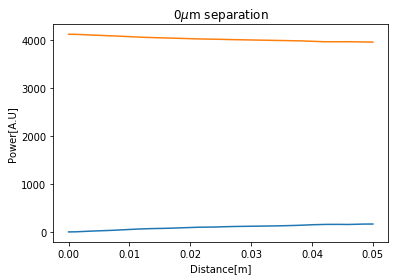

In [57]:
plt.plot([i*dz for i in range(n_runs)], powers2[:,1])
plt.plot([i*dz for i in range(n_runs)], powers2[:,0])
plt.xlabel("Distance[m]")
plt.ylabel("Power[A.U]")
plt.title(r"0$\mu$m separation")

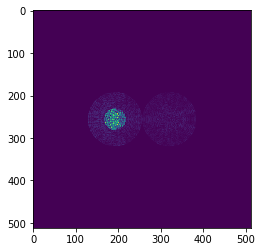

In [58]:
plt.imshow(np.abs(Gauss_beam))